# Geospatial subsetting data served by Hyrax
This notebook demonstrates simple subsetting geospatial data using the **grid()** and **geogrid()** server functions.

In the notebook we show how to use simple HTTP requests to look at metadata and how to use the PyDAP package to read data into numpy arrays and plot (or do other things) with those data. PyDAP provides lazy evaluation, so data are read only when needed. In addition, PyDAP supports using Hyrax's server functions that enable subsetting operations beyond those found in the APIs of most self describing formats. These tools provide a powerful way to offload common operations from the analysis software to the server, where many subsetting operations benefit from being performed 'close to the data.'

Only two server functions are demonstrated here; Hyrax includes 61 sever functions although only a some of those work directly with data. Each Hyrax instance can extend this set using modules loaded at run-time.

Copyright (C) 2020 OPeNDAP, Inc.
This Jupyter Notebook is made available under the [Creative Commons Attribution license 4.0](https://creativecommons.org/licenses/by/4.0/).

In [1]:
# The requests package provides a high-level interface to HTTP/S
import requests

# Install using 'conda install requests'

# Use the netCDF4 library to read data
# from netCDF4 import Dataset as NetCDFFile 
# import xarray as xr
from pydap.client import open_url
from pydap.cas.urs import setup_session

# Install using 'conda install -c conda-forge pydap'

# Use matplotlib and numpy for plotting and local data manipulation
import matplotlib.pyplot as plt
import numpy as np

# These are part of the conda base

# Using basemap with Anaconda/Jupyter and Python 3, I had to set this env var.
# I might have been able to do this in the shell that started the notebook server,
# but that would obfuscate a detail that seems to generate considerable traffic on
# Stackoverflow... jhrg 4/22/20
import os
os.environ['PROJ_LIB'] = '/Users/jimg/opt/anaconda3/pkgs/proj4-5.2.0-h0a44026_1/share/proj'

from mpl_toolkits.basemap import Basemap

# Install using 'conda install basemap'
# To plot hig resolution maps, use 'conda install basemap-data-highres'
# NB: We will need to shift to Cartopy soon...

The **grid()** and **geogrid()** functions work with _regularly gridded_ data, that is, data where the independent variables are held in vectors of rank $M$ and $N$ and the dependent variable(s) are of rank $M x N$. For this notebook, I'll use a dataset resident on our test server. It is a climatology dataset that holds Sea Surface and Air temperature as well as wind vectors and has global coverage. 

In [2]:
url='http://test.opendap.org/opendap/data/nc/coads_climatology.nc'

## Look at the metadata
Lets look at the dataset's contents, first by looking at the variables in the dataset. We can do this by appending the extension _dds_ to the dataset's URL. The _Data Access Protocol_ denotes the different kinds of responses from a dataset using extensions. The most important ones are:
- **dds** Get information about the variables
- **das** Get semantic (i.e., attributes) about the dataset and its variables
- **dods** Get binary data (for individual or groups of variables)
- **ascii** Get data as ASCII, really useful for looking at small parts or a dataset

In [3]:
r = requests.get(url + '.' + 'dds')

In [4]:
print(r.url)

http://test.opendap.org/opendap/data/nc/coads_climatology.nc.dds


In [5]:
print(r.text)

Dataset {
    Float64 COADSX[COADSX = 180];
    Float64 COADSY[COADSY = 90];
    Float64 TIME[TIME = 12];
    Grid {
      Array:
        Float32 SST[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } SST;
    Grid {
      Array:
        Float32 AIRT[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } AIRT;
    Grid {
      Array:
        Float32 UWND[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } UWND;
    Grid {
      Array:
        Float32 VWND[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } VWND;
} coads_climatology.nc;



From this we can see these data consist of four regularly gridded variables. 

Lets look at the dataset's attribute information. From this we can see the values used to denote 'missing' or filled values, units, etc.

In [6]:
r = requests.get(url + '.' + 'das')

In [7]:
print(r.text)

Attributes {
    COADSX {
        String units "degrees_east";
        String modulo " ";
        String point_spacing "even";
    }
    COADSY {
        String units "degrees_north";
        String point_spacing "even";
    }
    TIME {
        String units "hour since 0000-01-01 00:00:00";
        String time_origin "1-JAN-0000 00:00:00";
        String modulo " ";
    }
    SST {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "SEA SURFACE TEMPERATURE";
        String history "From coads_climatology";
        String units "Deg C";
    }
    AIRT {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "AIR TEMPERATURE";
        String history "From coads_climatology";
        String units "DEG C";
    }
    UWND {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "ZONAL WIND";
        String

## Peek at the data
Lets look at sea surface data over the Atlantic Ocean, pulling those values out of the dataset as ASCII. This would not be a good idea with millions of values, but for this dataset, it is not an issue. Later on, I'll show how you can so this using PyDAP, without the performance cost of having the server perform the conversion to ASCII. This is still a useful technique, even with larger datasets because when documentation and metadata leave you with questions, looking at a small set of values can be helpful.

For this, we will use the **grid()** server function - there are simpler ways to look at values, but this notebook is about server functions after all, so...

The **grid()** function takes a _grid_ variable, followed by a series of optional _expressions_. The expressions denote a range of values for the independent variables that make up the grid. In this case _COADSY_ and _COADSX_ are used. For any independent variables left unmentioned, grid() will return all the values. In this example below, we will get data that correspond to the values of _COADSY_ between 45 and -25, the values of _COADSX_ betwwen 20 and -100 and all the values corresponding to the TIME axis of the _SST_ grid.

In [8]:
ce = 'grid(SST,"45>COADSY>-25","40>COADSX>-100")'

In [9]:
r2 = requests.get(url + '.' + 'ascii', params=ce)

In [10]:
print(r2.url)

http://test.opendap.org/opendap/data/nc/coads_climatology.nc.ascii?grid(SST,%2245%3ECOADSY%3E-25%22,%2240%3ECOADSX%3E-100%22)


In [11]:
print(r2.text)

Dataset: function_result_coads_climatology.nc
SST.COADSX, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39
SST.SST[SST.TIME=366][SST.COADSY=-23], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, 27.4571, 27.6441, 27.6151
SST.SST[SST.TIME=366][SST.COADSY=-21], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, 28.015, 27.9252, 28.1689
SST.SST[SST.TIME=366][SST.COADSY=-19], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, 28.2141, 28.1051, 28.2814
SST.SST[SST.TIME=366][SST.COADSY=-17], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, 27.25, 28.3217
SST.SST[SST.TIME=366][SST.COADSY=-15], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34
SST.SST[SST.TIME=366][SST.COADSY=-13], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34
SST.SST[SST.TIME=366][SST.COADSY=-11], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, 28.45
SST.SST[SST.TIME=366][SST.COADSY=-9], -1e+34, -1e+34, -1e+34, -1e+34, 

## The geogrid() function
Unlike **grid()**, the **geogrid()** function is designed specifically for geospatial subsetting. While grid() works with _any_ grid, geogrid() works only with grids that contain geospatial information encoded using one of the standards/conventions it recognizes. 

The arguments to geogrid() are the name of a grid followed by the top, left, bottom, and right corners of a region. The function can also use the same kinds of relational expressions that grid() uses for any dimensions that are _not_ spatial, such as time.

In [12]:
ce2 = 'geogrid(SST,45,-100,-25,5)'

In [13]:
r3 = requests.get(url + '.' + 'ascii', params=ce2)

In [14]:
print(r3.text)

Dataset: function_result_coads_climatology.nc
SST.COADSX, -101, -99, -97, -95, -93, -91, -89, -87, -85, -83, -81, -79, -77, -75, -73, -71, -69, -67, -65, -63, -61, -59, -57, -55, -53, -51, -49, -47, -45, -43, -41, -39, -37, -35, -33, -31, -29, -27, -25, -23, -21, -19, -17, -15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5
SST.SST[SST.TIME=366][SST.COADSY=45], -1e+34, -1e+34, -1e+34, -1e+34, 11.8, 13.35, 5, 3.4525, 2.08211, 3.11619, 1.93412, 0.282222, 2.04833, 1.85, 1.38, -1e+34, 5.17045, 4.85225, 3.03658, 2.54795, 2.31841, 2.23136, 2.60409, 3.18341, 3.28205, 2.79864, 2.68773, 6.78432, 10.3032, 13.2623, 14.5636, 14.1607, 13.9793, 13.9482, 13.8066, 13.7819, 13.7068, 13.5852, 13.572, 13.4405, 13.2866, 13.1543, 12.9344, 12.8463, 12.76, 12.6668, 12.6811, 12.3766, 12.295, 12.2254, 10.3324, -1e+34, -1e+34, -1e+34
SST.SST[SST.TIME=366][SST.COADSY=43], -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, -1e+34, 3.12773, -1e+34, 2.2019, 2.18462, 3.2119, 2.99375, -1e+34, -1e+34, 4.70286, 5.68432, 5.18727, 3

## Using PyDAP to read values

In [15]:
pydap_ds = open_url(url)

In [16]:
print(pydap_ds)

<DatasetType with children 'COADSX', 'COADSY', 'TIME', 'SST', 'AIRT', 'UWND', 'VWND'>


In [17]:
pydap_ds.SST.shape

(12, 90, 180)

In [18]:
pydap_subset_ds = pydap_ds.functions.geogrid(pydap_ds.SST,75,-100,-25,20)

In [19]:
# pydap_subset_ds.SST.shape

### PyDAP only reads the data when  needed
The above call, just like the **open_url()** call, does not get data. The *access* to values in the cells below trigger the data transfers.

This assignment triggers a data read. Note that the grid 'SST' is being subset here.
Only the ''sliced' data are read. This is in addition to the subsetting performed by the grid() function. PyDAP enables constraints to be built up in this way, until an action like assignment triggers a read operation. This feature is often known as _lazy evaluation_ because the action can be _defined_ in stages and is not run until the values are needed.

In [20]:
# This assignement triggers a data request from the server
sst_data = pydap_subset_ds['SST'][0]

In [21]:
print(sst_data)

<GridType with array 'SST' and maps 'TIME', 'COADSY', 'COADSX'>


In [22]:
# sst_data.array[:].data
# sst_data.COADSX[:].data

sst_data.array.shape

# sst_data.COADSX.shape
# sst_data.COADSY.shape

(51, 61)

In [23]:
lon = sst_data.COADSX.data
lat = sst_data.COADSY.data
sst = sst_data.array.data

Text(0.5, 1.0, 'Sea Surface Temperature')

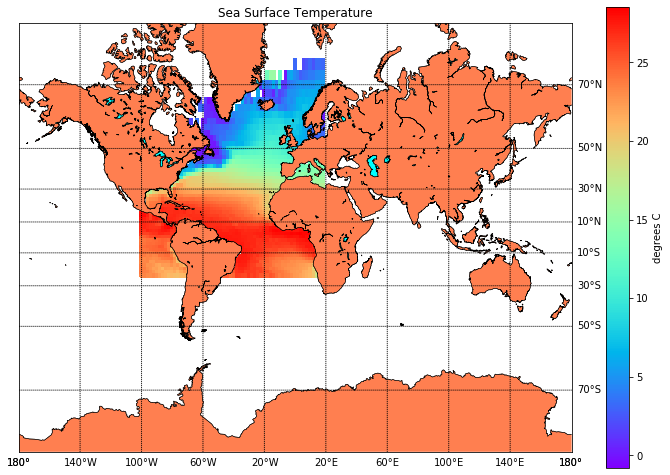

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

m = Basemap(
    llcrnrlon=-180,
    llcrnrlat=-80,
    urcrnrlon=180,
    urcrnrlat=80,
    resolution='l',
    projection='merc')

m.fillcontinents(color='coral',lake_color='aqua')

# draw lat and lon line (parallels and meridians).
# and set the axis labels (labels = [left,right,top,bottom])
parallels = np.arange(-70., 80., 20.)
m.drawparallels(parallels, labels=[False,True,False,False])
meridians = np.arange(-180., 180., 40.)
m.drawmeridians(meridians, labels=[False,False,False,True])

# Use meshgrid(lon, lat) to build matrices for the lon, lat values
# and then convert them to map projection coordinates for the Basemap
# object 'm.'
X, Y = m(*np.meshgrid(lon, lat))

# Remove the _FillValue value
sst[sst == -9.9999998e+33] = np.nan

# Plot using the rainbox color map
colors_ = m.pcolor(X, Y, sst, cmap=plt.get_cmap('rainbow'))

m.drawcoastlines(linewidth=0.5)

cb = plt.colorbar(colors_)
cb.set_label("degrees C")
m.drawcoastlines(linewidth=0.5)

ax.set_title('Sea Surface Temperature')